# Importy

In [65]:
%matplotlib notebook
import numpy as np
import random
import math
from utils import *
import enum
import matplotlib.pyplot as plt

# Narzędzie

In [82]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

FIG_EPS = 0.5

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
         
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
    
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < FIG_EPS:
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
        
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()

In [67]:
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)
    
class Plot:
    def __init__(self, scenes = [Scene()], json = None):
        if json is None:
            self.scenes = scenes
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
        
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
     
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
  
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        

# Zadawanie punktów
Najłatwiej punkty jest zadawać za pomocą funkcji `get_added_elements()` z `Plot` i wrzucić je do kolejnego `Plot`

/tmp/ipykernel_2649/2671438789.py:89: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  plt.close()


<IPython.core.display.Javascript object>


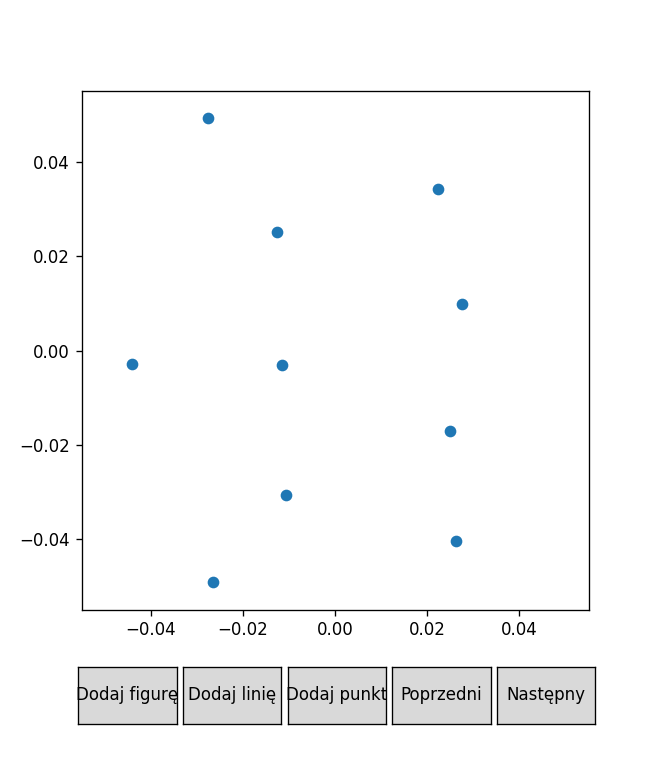

In [165]:
plot1 = Plot()
plot1.draw()

/tmp/ipykernel_2649/2671438789.py:89: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  plt.close()


<IPython.core.display.Javascript object>


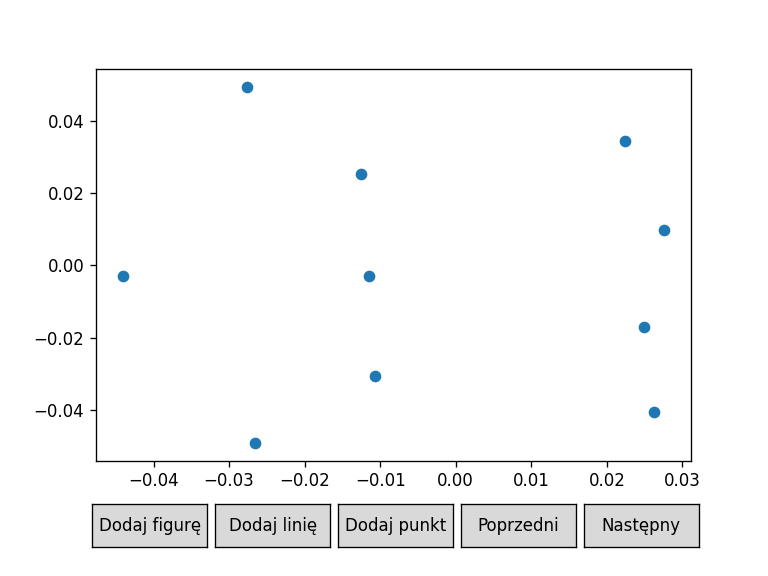

In [166]:
plot2 = Plot([plot1.get_added_elements()])
plot2.draw()

# Helper functions

In [139]:
def det(a,b,c):
    return a[0]*b[1]+a[1]*c[0]+b[0]*c[1]-c[0]*b[1]-a[1]*b[0]-a[0]*c[1]

# Point types

In [140]:
class Point_type(enum.Enum):
    start = 1
    end = 2
    joining = 3
    dividing = 4
    regular = 5

class Point_side(enum.Enum):
    left = 1
    right = 2
    both = 3

In [142]:
lines1 = [[(-2.2172004945822388e-05, -0.05009651146683039),
  (0.03546169896279612, -0.038638178133497056)],
 [(0.03546169896279612, -0.038638178133497056),
  (0.020824602188602562, -0.03156097225114411)],
 [(0.020824602188602562, -0.03156097225114411),
  (0.04189315057569934, -0.017069550682516657)],
 [(0.04189315057569934, -0.017069550682516657),
  (0.02215524734989288, -0.00864430558447743)],
 [(0.02215524734989288, -0.00864430558447743),
  (0.045219763478925146, 0.006184125788071593)],
 [(0.045219763478925146, 0.006184125788071593),
  (0.023042344124086442, 0.016631429709640225)],
 [(0.023042344124086442, 0.016631429709640225),
  (0.03679234412408644, 0.030111821866502964)],
 [(0.03679234412408644, 0.030111821866502964),
  (-0.05014313974688131, 0.04696231206258139)],
 [(-0.05014313974688131, 0.04696231206258139),
  (-0.05058668813397808, -0.015047491858987239)],
 [(-0.05058668813397808, -0.015047491858987239),
  (-0.022864913940429693, -0.032572001662908814)],
 [(-0.022864913940429693, -0.032572001662908814),
  (-0.04703830103720389, -0.05144455068251667)],
 [(-0.04703830103720389, -0.05144455068251667),
  (-2.2172004945822388e-05, -0.05009651146683039)]]

In [143]:
lines2 = [[(0.009790845071115856, 0.4858359883813305),
  (1.0011214902324062, 0.040983047204859846)],
 [(1.0011214902324062, 0.040983047204859846),
  (0.7771295547485354, 0.287000204067605)],
 [(0.7771295547485354, 0.287000204067605),
  (0.9789440708775675, 0.3375516746558403)],
 [(0.9789440708775675, 0.3375516746558403),
  (0.8103956837807934, 0.45213500798917367)],
 [(0.8103956837807934, 0.45213500798917367),
  (0.9634198773291806, 0.55660804720486)],
 [(0.9634198773291806, 0.55660804720486),
  (0.7815650386195031, 0.630750204067605)],
 [(0.7815650386195031, 0.630750204067605),
  (0.9545489095872451, 0.8194756942636836)],
 [(0.9545489095872451, 0.8194756942636836),
  (0.7593876192646644, 0.846436478577409)],
 [(0.7593876192646644, 0.846436478577409),
  (0.8968876192646643, 0.9879805962244679)],
 [(0.8968876192646643, 0.9879805962244679),
  (0.009790845071115856, 0.4858359883813305)]]

In [144]:
class Visualiser:  
    def __init__(self):
        self.scenes = []
        
    def get_scenes(self):
        return self.scenes
    
    def make_starts(l):
        return [i[0] for i in l]
    
    def make_ends(l):
        return [i[1] for i in l]
    
    def put_scene(self, l, points = [], color = 'blue', points_color='orange'):
        tab = [ PointsCollection(Visualiser.make_starts(l), color='blue'), PointsCollection(Visualiser.make_ends(l), color='green')]
        if len(points) > 0:
            tab.append(PointsCollection(points,color=points_color))
        self.scenes.append(Scene( tab, 
                              [ LinesCollection(l,color=color)])) 
    def put_points_classification(self, lines, points, points_class, class_type = 'classification' , lines_color = 'blue'):
        if class_type == 'classification':
            colors = {
                Point_type.start : 'green',
                Point_type.end : 'orange',
                Point_type.joining : 'pink',
                Point_type.dividing : 'lightblue', 
                Point_type.regular : 'brown'
            }
        else:
            colors = {
                Point_side.left : 'green',
                Point_side.right : 'red',
                Point_side.both : 'khaki'
            }
        
        self.scenes.append(Scene([PointsCollection([points[i]], color=colors[points_class[i]]) for i in range(len(points))],
                                 [LinesCollection(lines, color = lines_color)]))

    def get_triangle_sides(triangle):
        return [[triangle[0],triangle[1]],
                [triangle[1],triangle[2]],
                [triangle[0],triangle[2]]]

    def put_triangulation(self, lines, points, triangulation, triangulation_color='orange', lines_color = 'blue', points_color='blue', from_traingles=True):
        if from_traingles:
            trian = [Visualiser.get_triangle_sides(t) for t in triangulation]
            triangulation = [item for sublist in trian for item in sublist]
        self.put_scene(lines, points, lines_color, points_color)
        self.scenes[-1].lines.append(LinesCollection(triangulation, color=triangulation_color))
    
    def put_triangle(self, lines, points, triangulation, triangle, triangulation_color='orange', triangle_color = 'green', lines_color = 'blue', points_color='blue'):
        self.put_triangulation(lines, points, triangulation, triangulation_color, lines_color, points_color)
        t = Visualiser.get_triangle_sides(triangle)
        self.scenes[-1].lines.append(LinesCollection(t ,color=triangle_color))

In [145]:
def get_plot_points(plot):
    points_collection = plot.get_added_points()
    if len(points_collection) == 0:
        return []
    return points_collection[0].points

In [146]:
def figure_to_lines(points):
    lines = []
    for i in range(len(points)):
        start = points[i]
        end = points[(i+1) % len(points)]
        lines.append([start, end])
    return lines

<IPython.core.display.Javascript object>


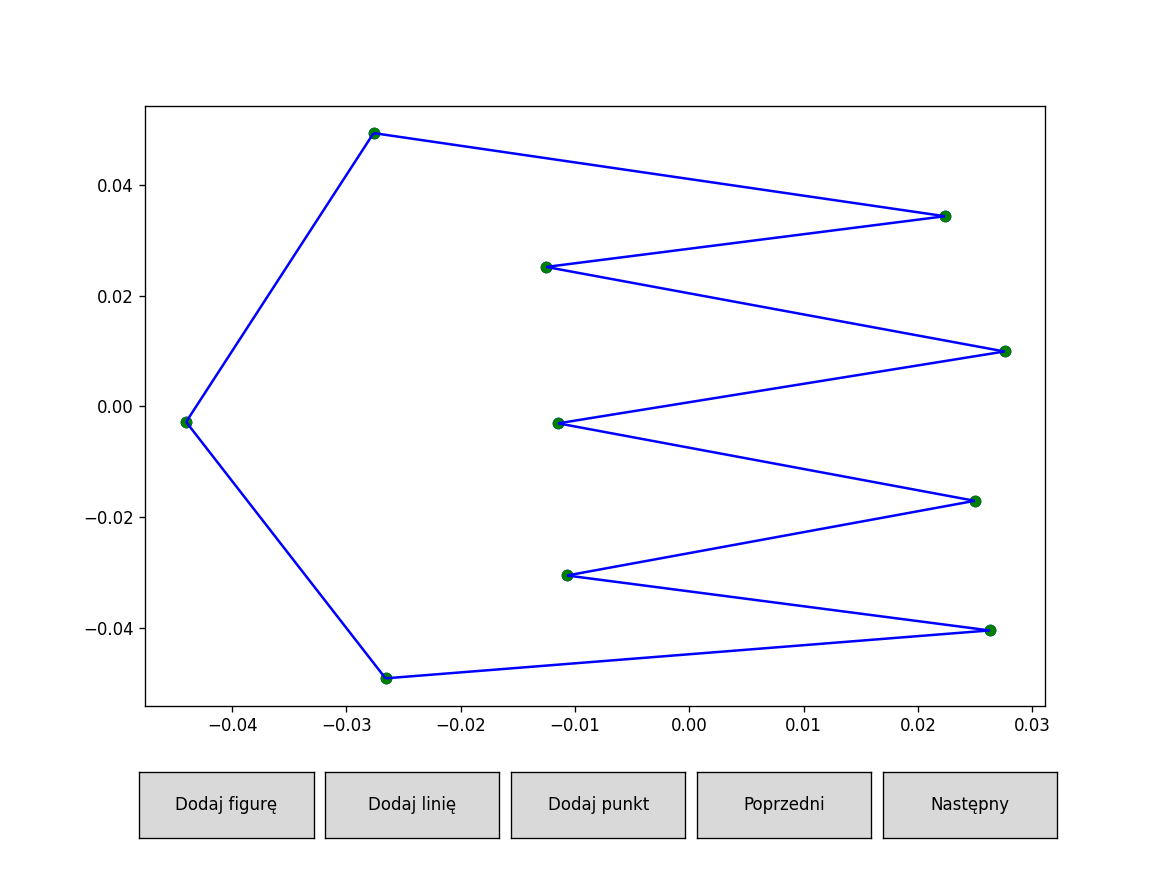

In [171]:
%matplotlib notebook
visualiser = Visualiser()
visualiser.put_scene(figure_to_lines(get_plot_points(plot1)))
plot = Plot(visualiser.get_scenes())
plot.draw()

<IPython.core.display.Javascript object>


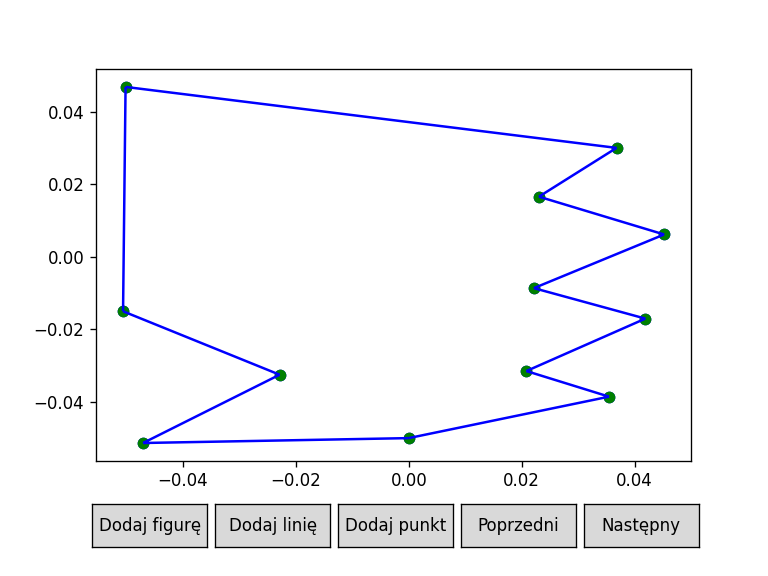

In [148]:
%matplotlib notebook
visualiser = Visualiser()
visualiser.put_scene(lines1)
plot = Plot(visualiser.get_scenes())
plot.draw()

<IPython.core.display.Javascript object>


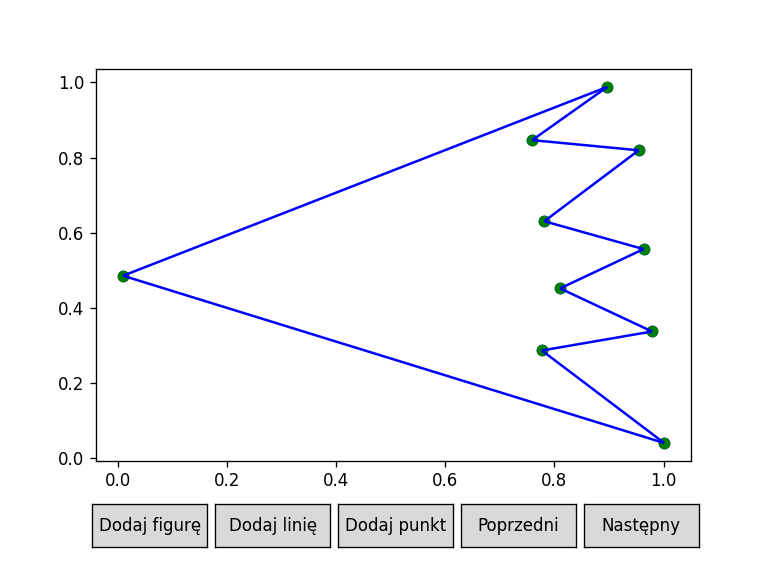

In [149]:
%matplotlib notebook
visualiser = Visualiser()
visualiser.put_scene(lines2)
plot = Plot(visualiser.get_scenes())
plot.draw()

In [150]:
def lines_to_points_series(lines):
    return [i[1] for i in lines]

def make_classification(lines, visualiser=None, e =10**-14):
    points_series = lines_to_points_series(lines)
    res = [0 for _ in range(len(points_series))]
    for i in range(len(points_series)+2):
        b_index = (i+1) % len(points_series)
        a = points_series[i % len(points_series)]
        b = points_series[b_index]
        c = points_series[(i+2) % len(points_series)]
        
        d = det(a,b,c)
        if a[1] < b[1] and c[1] < b[1]:
            if d > e:
                res[b_index] = Point_type.start
            else:
                res[b_index] = Point_type.dividing
        elif a[1] > b[1] and c[1] > b[1]:
            if d > e:
                res[b_index] = Point_type.end
            else:
                res[b_index] = Point_type.joining
        else:
            res[b_index] = Point_type.regular
    if visualiser is not None:
        visualiser.put_points_classification(lines, points_series, res)
    return res

/tmp/ipykernel_2649/2671438789.py:89: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  plt.close()


<IPython.core.display.Javascript object>


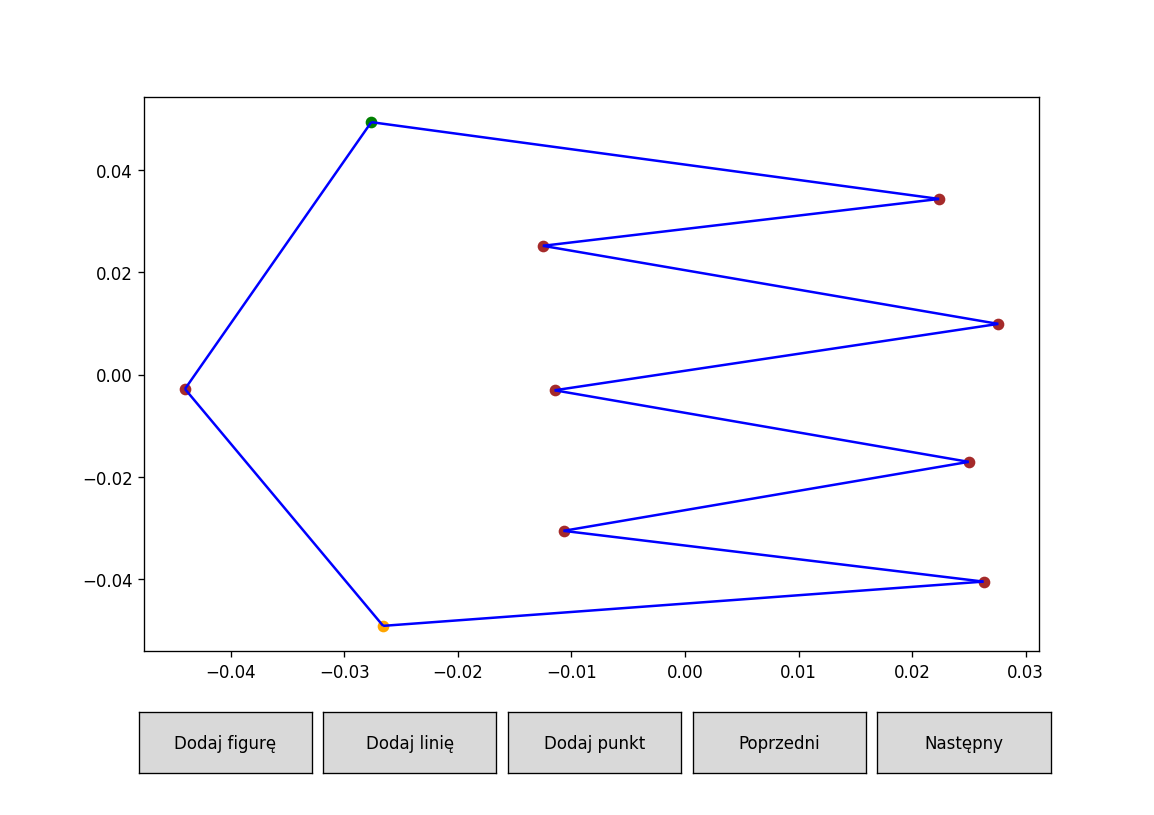

In [172]:
visualiser = Visualiser()

make_classification(figure_to_lines(get_plot_points(plot1)), visualiser)

plot = Plot(visualiser.get_scenes())
plot.draw()

/tmp/ipykernel_2649/2671438789.py:89: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  plt.close()


<IPython.core.display.Javascript object>


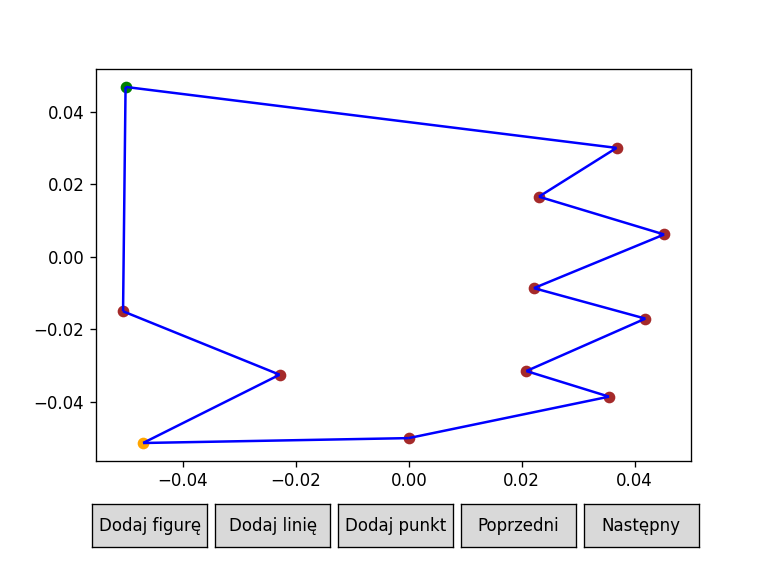

In [152]:
visualiser = Visualiser()

make_classification(lines1, visualiser)

plot = Plot(visualiser.get_scenes())
plot.draw()

/tmp/ipykernel_2649/2671438789.py:89: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  plt.close()


<IPython.core.display.Javascript object>


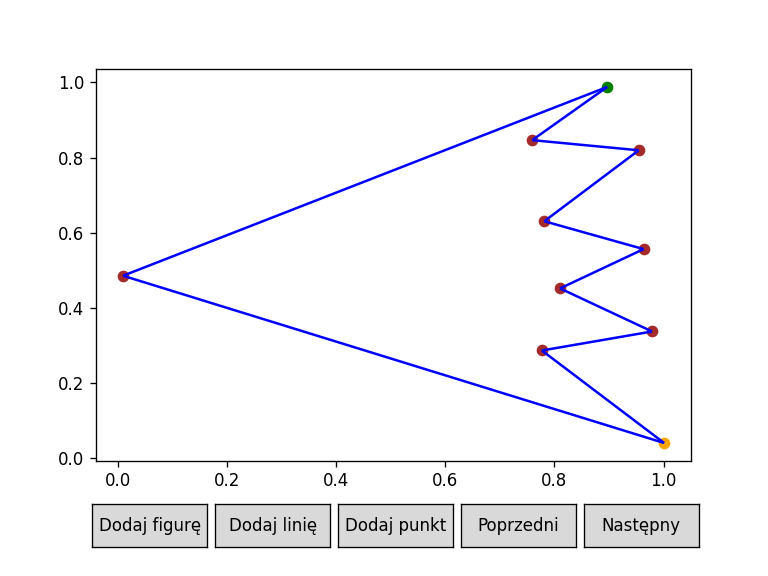

In [153]:
visualiser = Visualiser()

make_classification(lines2, visualiser)

plot = Plot(visualiser.get_scenes())
plot.draw()

In [154]:
def test_monotonous(lines, classification = None):
    if classification is None:
        classification = make_classification(lines)
    for i in classification:
        if i == Point_type.dividing or i==Point_type.joining:
            return False
    return True

In [169]:
test_monotonous(figure_to_lines(get_plot_points(plot1)))

True

In [156]:
test_monotonous(lines1)

True

In [157]:
test_monotonous(lines2)

True

# Triangulacja

In [158]:
class Point:
    def __init__(self, pos, side, classification):
        self.pos = pos
        self.side = side
        self.classification = classification
        
    def __gt__(self, other):
        return self.pos[1] > other.pos[1]

In [162]:
def prepare_Points(points_series, side, classification):
    return [Point(points_series[i], side[i], classification[i]) for i in range(len(points_series))]

def check_if_inside(a,b,c, e = 10**-14):
    d = det(a.pos, b.pos, c.pos)
    if c.side == Point_side.left:
        return d < - e
    return d  > e

def sides_equal(a,b):
    if a.side == Point_side.both or b.side == Point_side.both:
        return True
    return a.side==b.side

def mark_sides(points_series, classification):
    side = [Point_side.right for i in range(len(points_series))]
    a = 0
    while a < len(points_series) and classification[a] != Point_type.start:
        a+=1
    side[a] = Point_side.both
    a+=1
    while classification[a % len(points_series)] != Point_type.end:
        side[a%len(points_series)] = Point_side.left
        a+=1
    side[a% len(points_series)] = Point_side.both
    return side

def put_triangle(result, a,b,c, lines, points,  visualiser=None):
    t = [a.pos,b.pos,c.pos]
    result.append(t)
    if visualiser is not None:
        visualiser.put_triangle(lines, points, result, t)

In [164]:
def triangulate(lines, visualiser=None):   
    points_series = lines_to_points_series(lines)
    classification = make_classification(lines)
    
    if visualiser is not None:
        visualiser.put_scene(lines)
    if not test_monotonous(lines, classification):
        return []  
    
    side = mark_sides(points_series, classification)
    points = sorted(prepare_Points(points_series, side, classification))
    
    stack = [points[0],points[1]]
    i = 2
    res = []
    while i < len(points):
        if  not sides_equal(stack[-1], points[i]):
            for k in range(len(stack)-1,0,-1):
                put_triangle(res, stack[k], stack[k-1], points[i], lines, points_series, visualiser)
            stack = [stack[-1], points[i]]
        else:
            new_stack = []
            while len(stack) >= 2:
                if check_if_inside(stack[-2], stack[-1], points[i]):
                    put_triangle(res,stack[-2], stack[-1], points[i], lines, points_series, visualiser)
                    stack.pop()
                else: 
                    new_stack.append(stack.pop()) 
            new_stack.append(stack.pop())
            new_stack.reverse()
            new_stack.append(points[i])
            stack = new_stack
        i += 1

    if visualiser is not None:
        visualiser.put_triangulation(lines, points_series, res)     
    return res

# Wizualizacja triangulacji
Za pomocą klasy visualiser możemy wyświetlać kolejne kroki algorytmu

7


/tmp/ipykernel_2649/2671438789.py:89: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  plt.close()


<IPython.core.display.Javascript object>


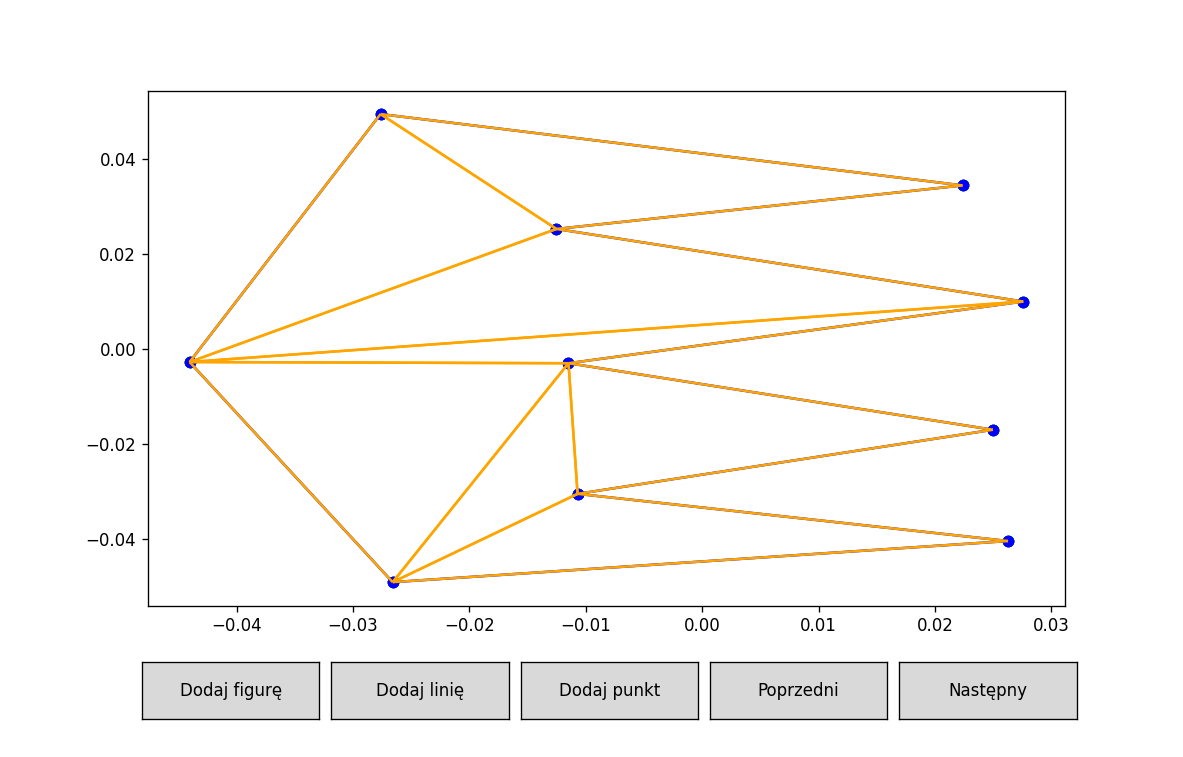

In [173]:
visualiser = Visualiser()

triangulate(figure_to_lines(get_plot_points(plot1)),visualiser)

plot = Plot(visualiser.get_scenes())
plot.draw()

7


/tmp/ipykernel_2649/2671438789.py:89: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  plt.close()


<IPython.core.display.Javascript object>


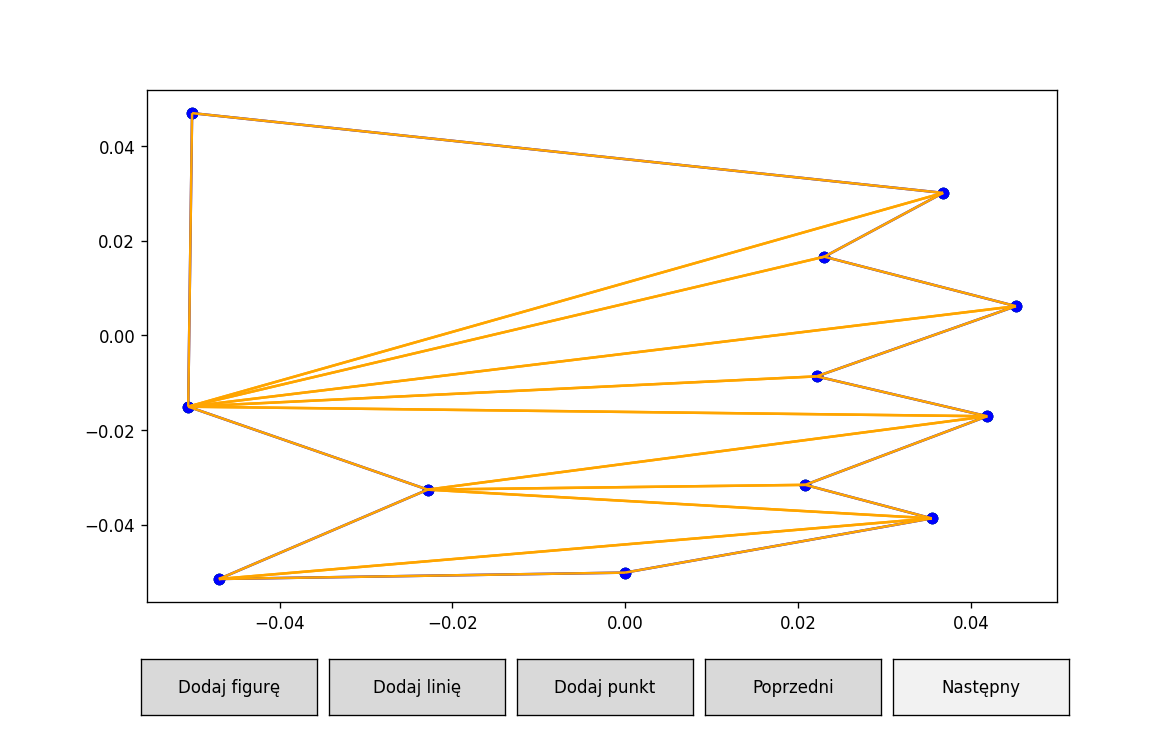

In [174]:
visualiser = Visualiser()

triangulate(lines1, visualiser)

plot = Plot(visualiser.get_scenes())
plot.draw()

8


/tmp/ipykernel_2649/2671438789.py:89: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  plt.close()


<IPython.core.display.Javascript object>


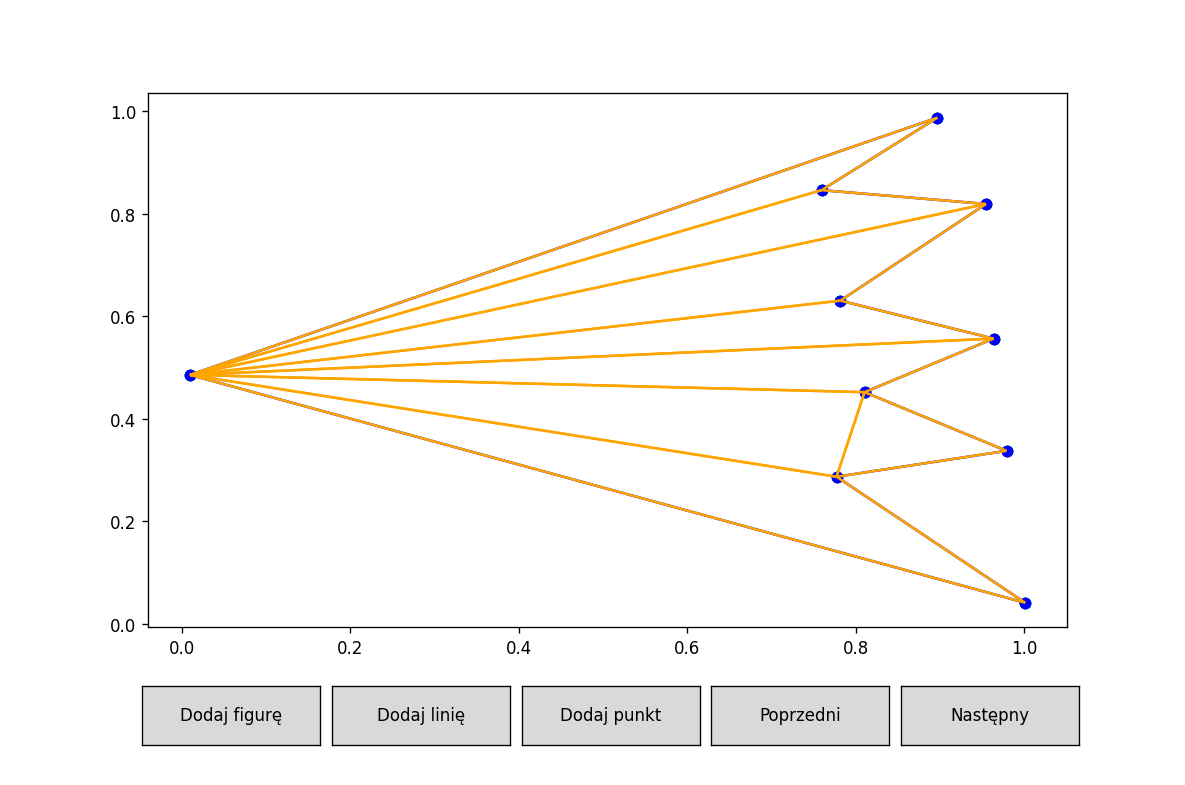

In [175]:
visualiser = Visualiser()

triangulate(lines2, visualiser)

plot = Plot(visualiser.get_scenes())
plot.draw()